In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

templist = [25, 30]
runlist = [[1433, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442],
           [1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451]]
bias = np.array([[53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8]])

In [2]:
def processTemperature(arr, idx):

    df = pd.DataFrame(columns=['chan', 'slope', 'temp', 'intercept', 'r_value', 'p_value', 'std_err', 'Vbd',])

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%templist[idx])

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("SPE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias[idx]
            y=arSPE[:, 0, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d"%(chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)

            new_row = {'chan': chan, 'slope': slope, 'temp': temp, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept, slope, ratio))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');
    return df

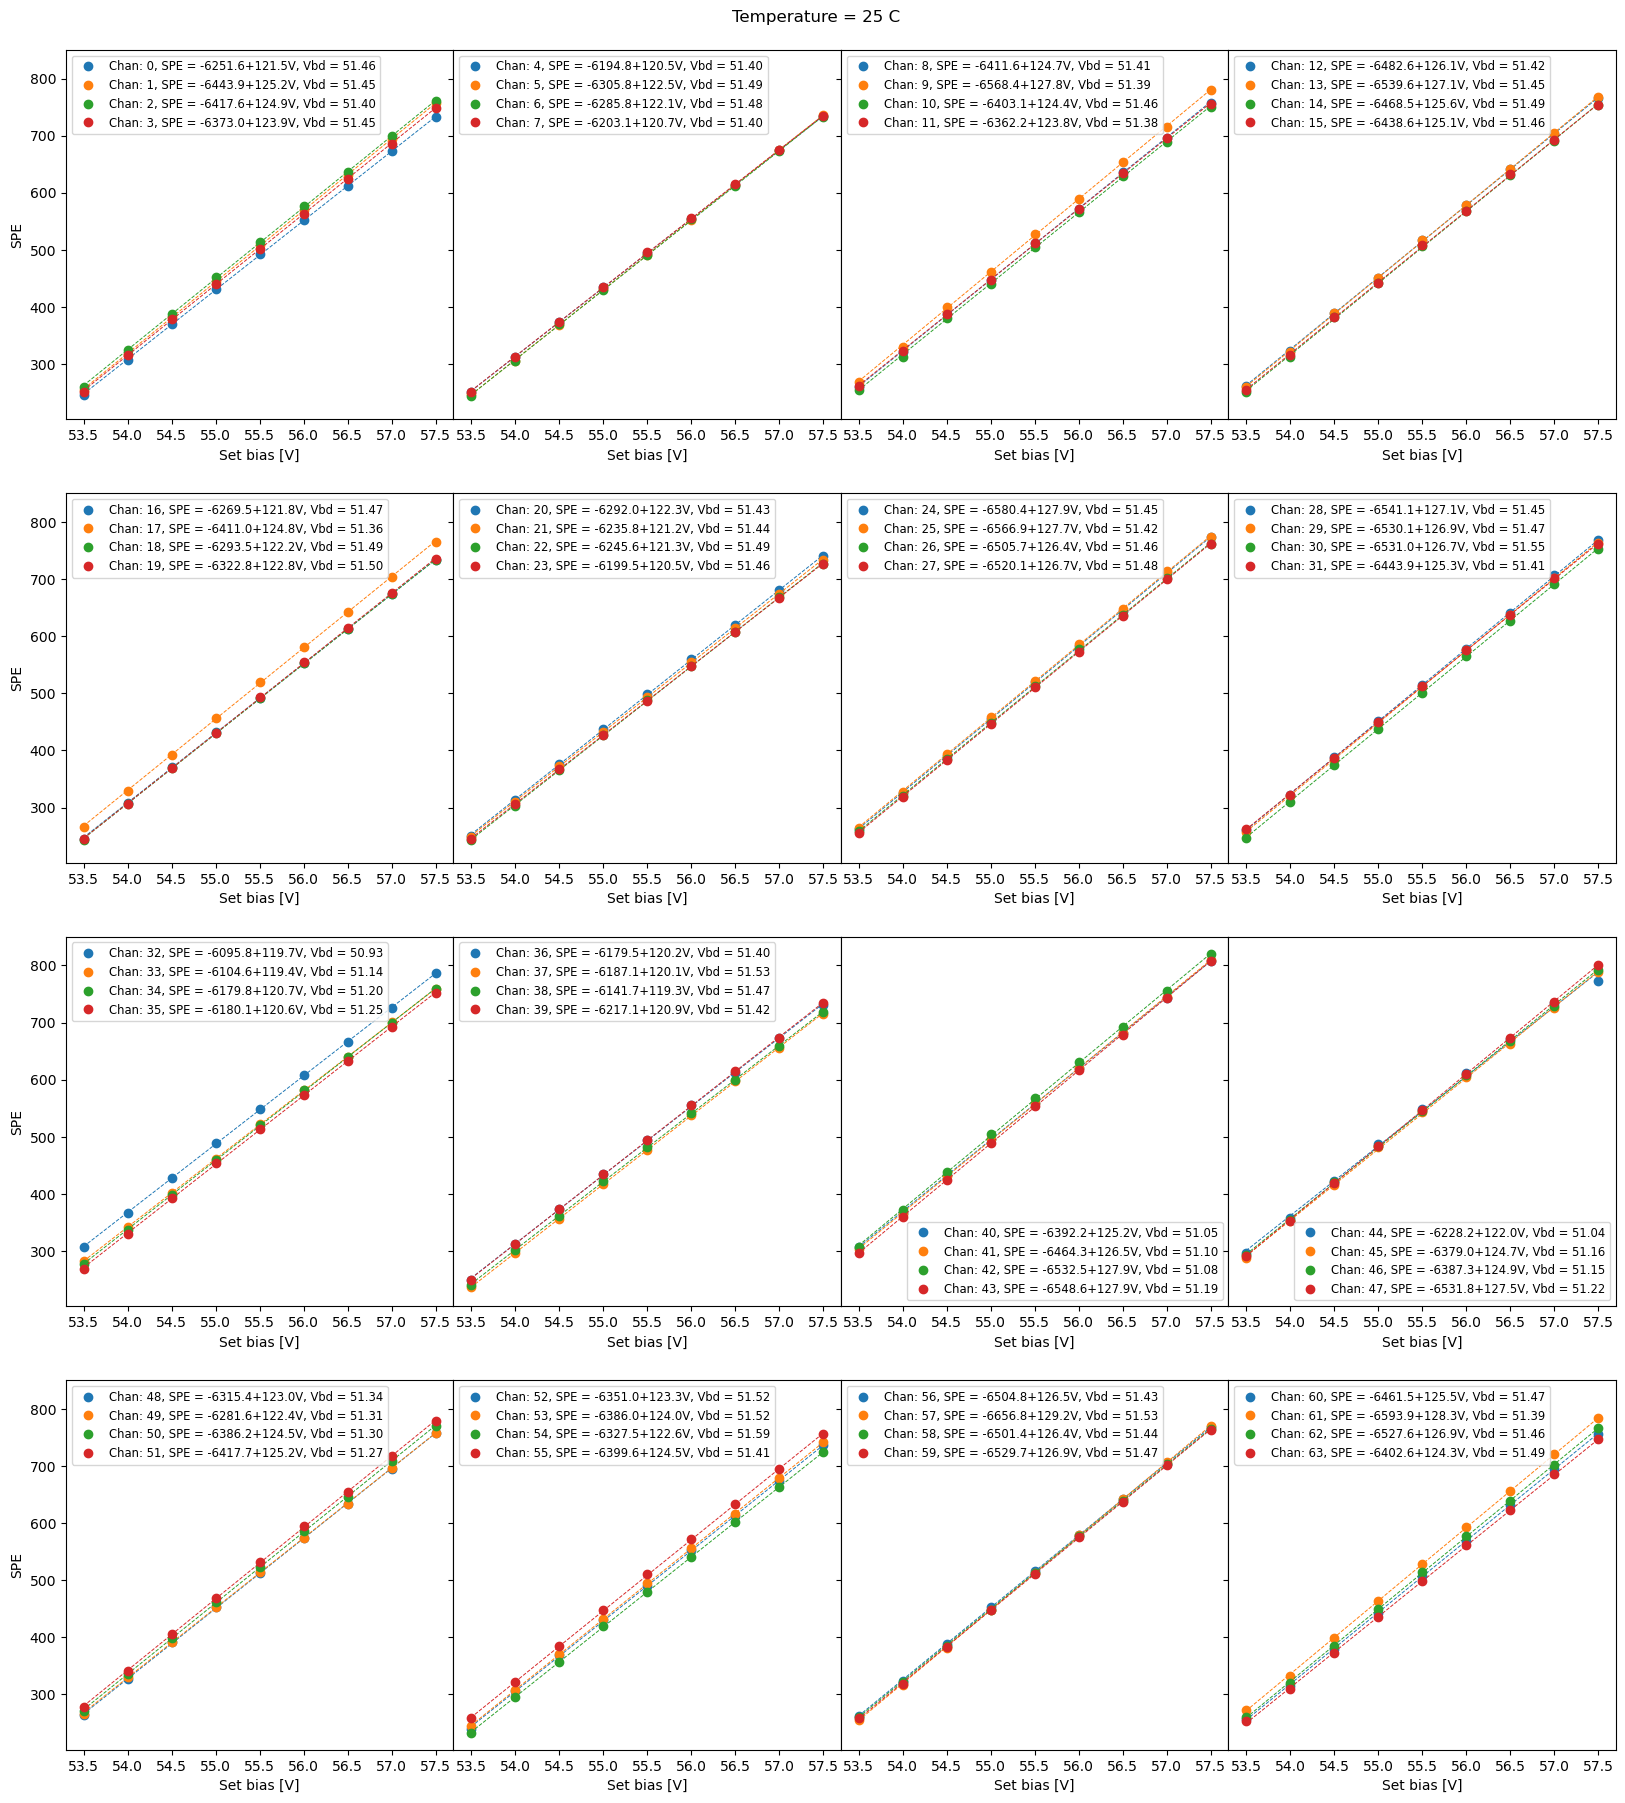

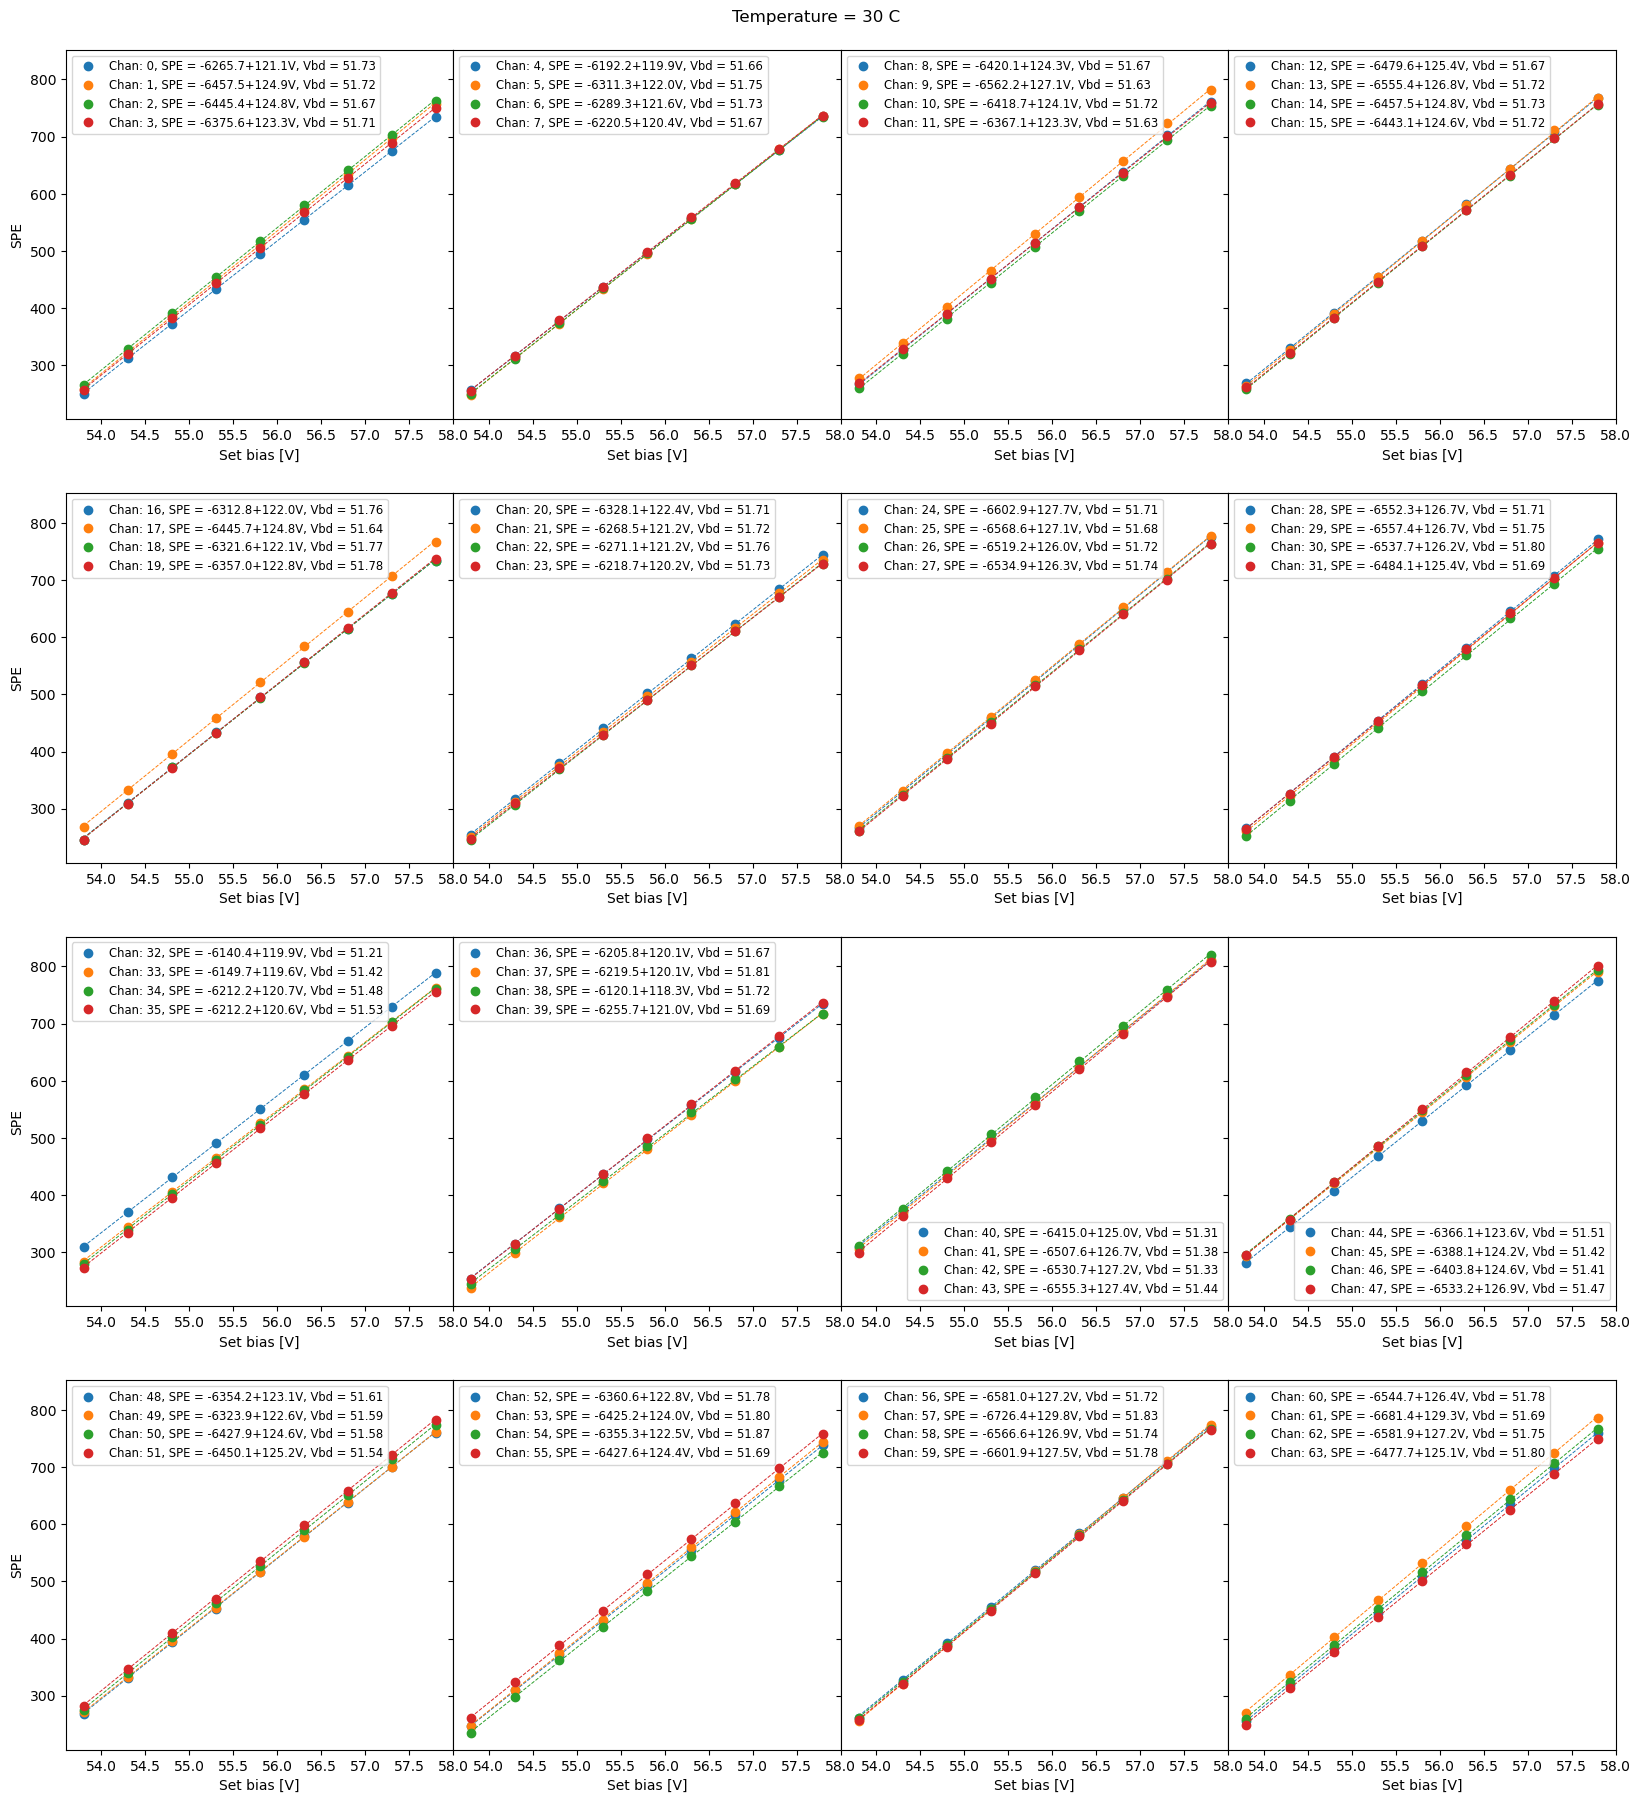

In [3]:
df = pd.DataFrame()

for idx, temp in enumerate(templist):
    processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist[idx], userunlist=True, remove=False)
    arr, arSpills = processor.getData(DATASET) # get akward array for "run" tree
    
    if not np.array_equal(np.array(runlist[idx]), arr['runNumber'].to_numpy()):
        print("Input run list order and data do not match")
    
    #Mask channels which were not calibrated
    var = 'calibConstants'    
    arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()
    
    df_tmp = processTemperature(arSPE, idx)
    df = pd.concat([df, df_tmp], ignore_index=True)

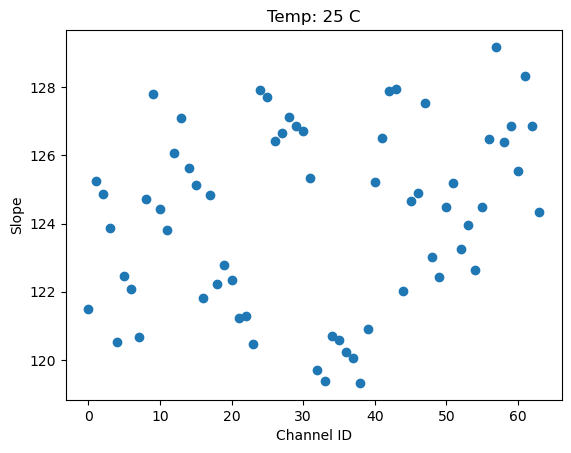

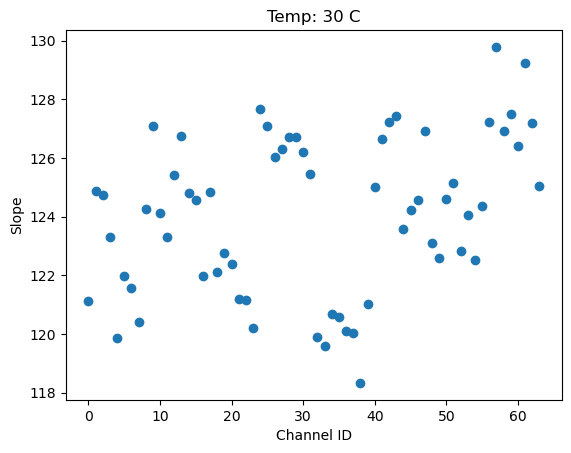

In [4]:
for temp in templist:
    plt.figure()
    plt.plot(df.query('temp == %d'%temp)['chan'], df.query('temp == %d'%temp)['slope'], 'o')
    plt.xlabel("Channel ID")
    plt.ylabel("Slope");
    plt.title('Temp: %d C'%temp)

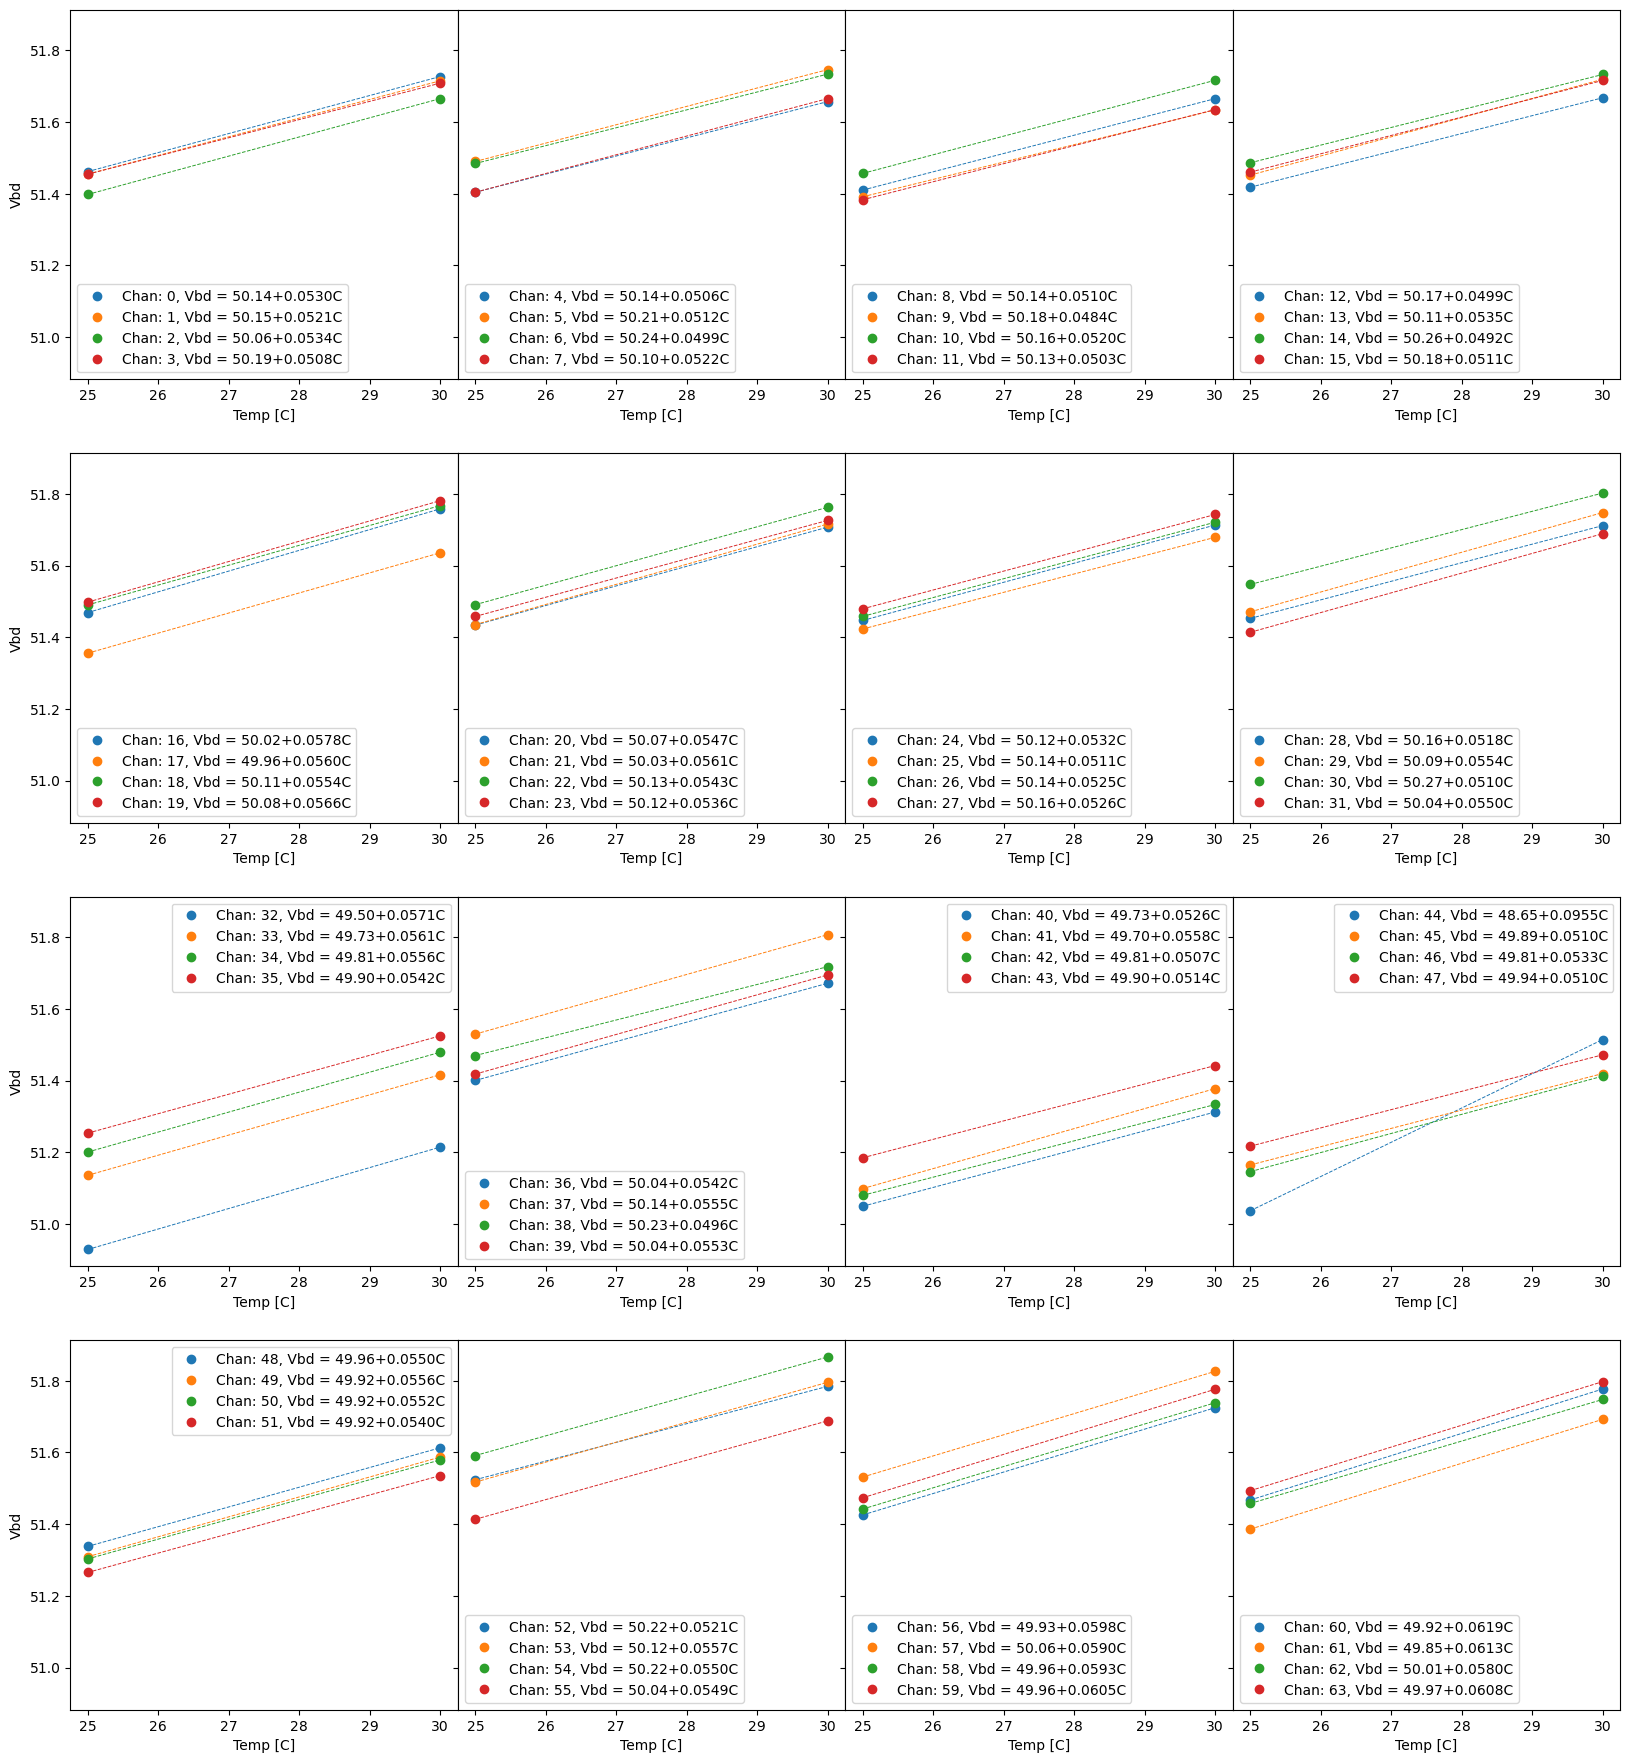

In [23]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("Vbd")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['Vbd']

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, Vbd = %.2f+%.4fC'%(chan, intercept, slope))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.legend()

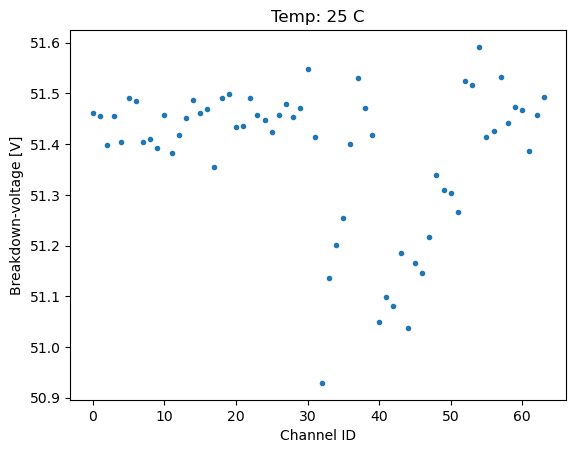

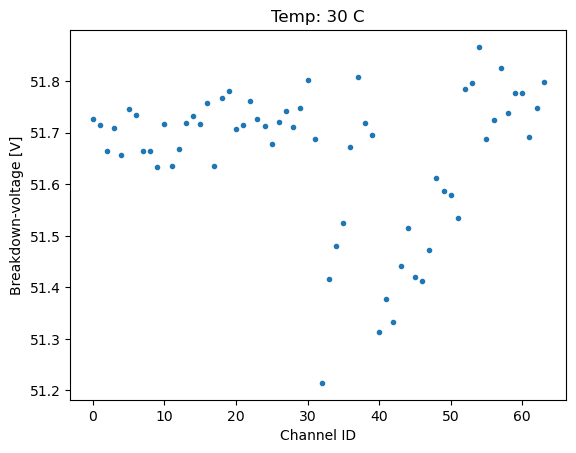

In [5]:
for temp in templist:
    plt.figure()
    plt.plot(df.query('temp == %d'%temp)['chan'], df.query('temp == %d'%temp)['Vbd'], '.')
    plt.xlabel("Channel ID")
    plt.ylabel("Breakdown-voltage [V]");
    plt.title('Temp: %d C'%temp)

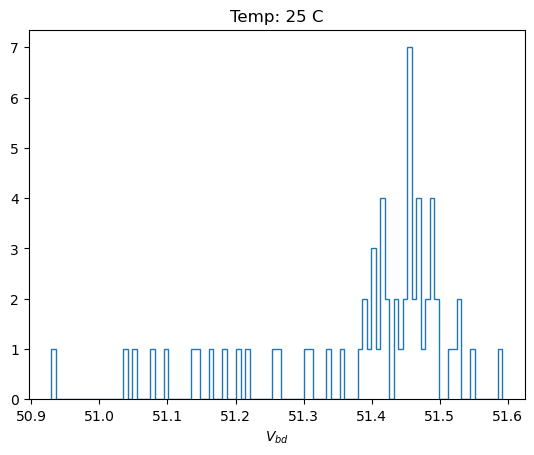

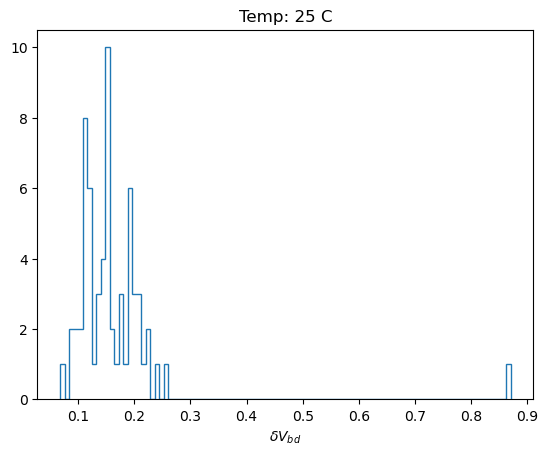

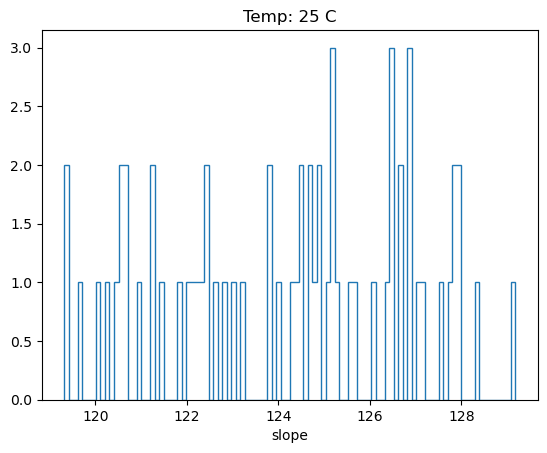

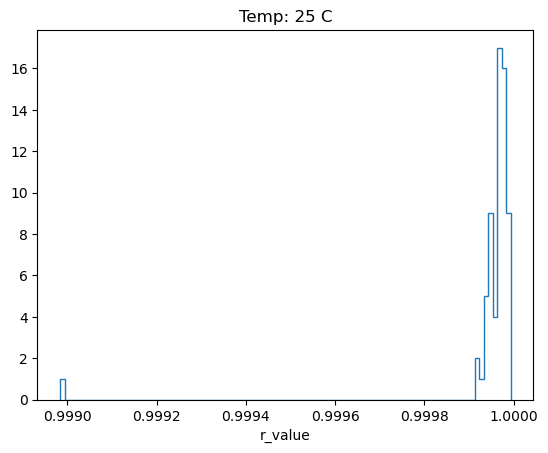

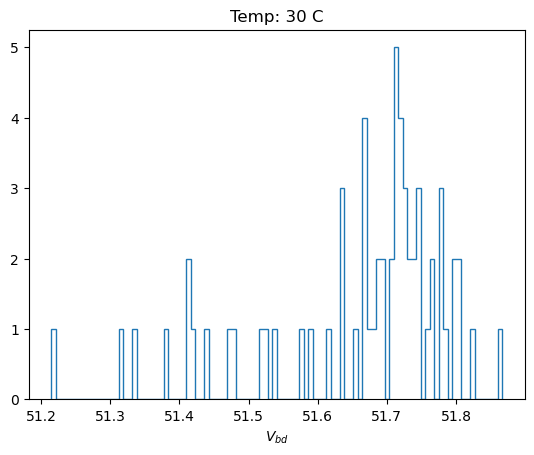

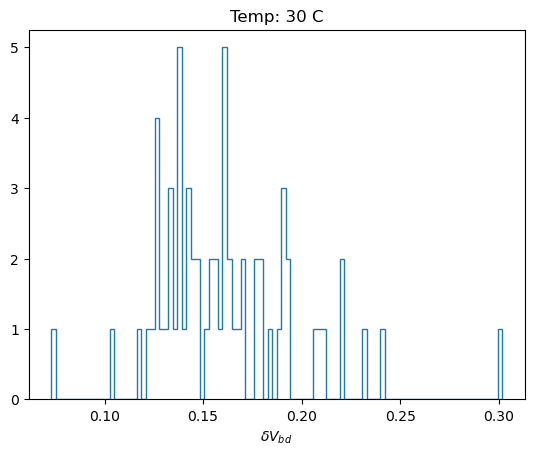

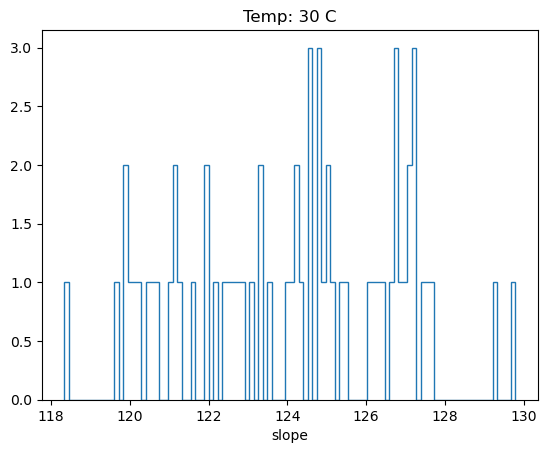

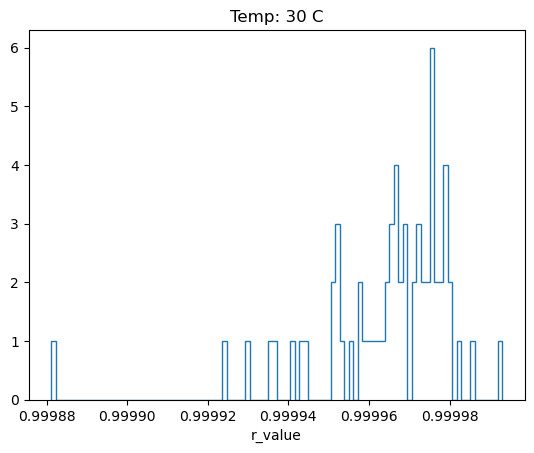

In [6]:
for temp in templist:

    plt.figure()
    plt.hist(df.query('temp == %d'%temp)['Vbd'], bins=100, histtype='step');
    plt.xlabel('$V_{bd}$');
    plt.title('Temp: %d C'%temp)
    
    plt.figure()
    plt.hist(df.query('temp == %d'%temp)['std_err'], bins=100, histtype='step');
    plt.xlabel('std_err');
    plt.xlabel('$\delta V_{bd}$')
    plt.title('Temp: %d C'%temp)

    plt.figure()
    plt.hist(df.query('temp == %d'%temp)['slope'], bins=100, histtype='step');
    plt.title('Temp: %d C'%temp)
    plt.xlabel('slope');

    plt.figure()
    plt.hist(df.query('temp == %d'%temp)['r_value'], bins=100, histtype='step');
    plt.title('Temp: %d C'%temp)
    plt.xlabel('r_value');

In [7]:
pd.set_option('display.max_rows', None)
df

,chan,slope,temp,intercept,r_value,p_value,std_err,Vbd
0,0,121.480573,25,-6251.615286,0.999983,6.531117e-17,0.113078,51.461852
1,1,125.234564,25,-6443.916110,0.999980,1.220840e-16,0.123632,51.454773
2,2,124.861470,25,-6417.640782,0.999949,3.057176e-15,0.195647,51.398088
3,3,123.855997,25,-6372.963506,0.999968,6.019919e-16,0.155283,51.454622
4,4,120.511333,25,-6194.773860,0.999984,5.151102e-17,0.109185,51.404077
5,5,122.467263,25,-6305.840311,0.999983,6.971855e-17,0.114201,51.490008
6,6,122.091268,25,-6285.786926,0.999970,4.854367e-16,0.150669,51.484328
7,7,120.673307,25,-6203.114862,0.999966,7.333724e-16,0.159569,51.404200
8,8,124.714830,25,-6411.630496,0.999956,1.788369e-15,0.181262,51.410330
9,9,127.810136,25,-6568.368732,0.999946,3.848666e-15,0.202164,51.391611
